# Deep Learning, Linear Layers, and PCA/ICA

Thomas Breuel

In [20]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
import seaborn as sns

import torch
from torchmore import flex
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import linalg as LA
from sklearn import decomposition

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [21]:
from tutlib.pcaica import N, showgrid, plot_pca_variance


In [22]:
train_ds = list(datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor()))
images = np.concatenate([x[0].view(1, -1).numpy() for x in train_ds], axis=0)
classes = np.array([x[1] for x in train_ds])
cuimages = torch.stack([x[0].view(-1) for x in train_ds]).to(device)
print(images.shape, cuimages.shape)

(60000, 784) torch.Size([60000, 784])


# Analyzing Hidden Layers

## Training a Fully Connected Model

In [23]:
def make_model():
    model = nn.Sequential(
        flex.Linear(100),
        nn.ReLU(),
        flex.Linear(10),
    )
    flex.shape_inference(model, (7, 784))
    return model.to(device)

make_model()

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [24]:
def train_batch(model, opt, xs, target):
    opt.zero_grad()
    xs = xs.view(xs.shape[0], -1).to(device)
    y = model(xs)
    loss = F.cross_entropy(y, target.to(device))
    loss.backward()
    opt.step()
    err = (y.argmax(dim=1) != target.to(device)).float().mean()
    return float(loss), float(err)

In [25]:
def train_mnist(model, train_ds=train_ds, nepochs=50, batch_size=256, lr=0.3):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(next(iter(train_dl))[0].shape)
    opt = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(nepochs+1):
        log = []
        for xs, cs in train_dl:
            loss, err = train_batch(model, opt, xs, cs)
            log.append((loss, err))
        loss, err = np.mean(log, axis=0)
        if epoch % 10 == 0:
            print(f"{epoch:2d} loss {loss:.3f} err {err:.3f}")

In [26]:
nn100 = make_model()
train_mnist(nn100)

torch.Size([256, 1, 28, 28])
 0 loss 0.512 err 0.139
10 loss 0.073 err 0.021
20 loss 0.038 err 0.010
30 loss 0.023 err 0.005
40 loss 0.014 err 0.002
50 loss 0.009 err 0.001


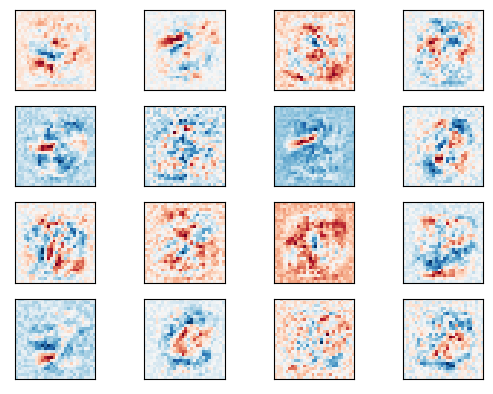

In [27]:
W = N(nn100[0].weight)
showgrid(W, cmap=cm.RdBu)

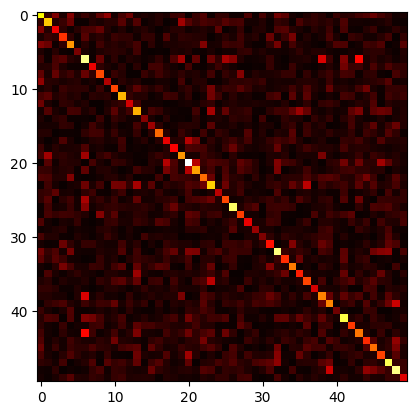

In [28]:
imshow(abs(dot(W, W.T))[:50, :50], cmap=cm.hot)

# SUMMARY

Input units tend towards being imperfectly orthonormal (up to a scale factor).

To the degree that input layers approximate a PCA, the vectors are mixed.

## Output of the First Linear Layer

In [29]:
nn100lin = N(nn100[:1](cuimages))
nn100lin.shape

(60000, 100)

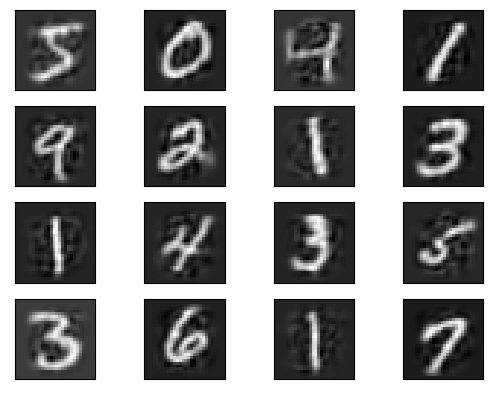

In [30]:
nn100recon = dot(nn100lin, dot(pinv(nn100lin), images))
showgrid(nn100recon)

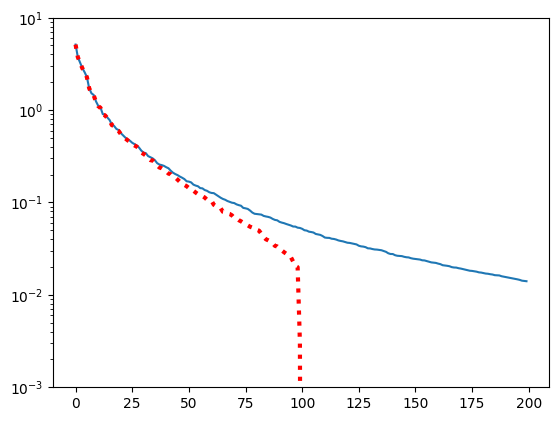

In [31]:
yscale("log"); ylim((1e-3, 1e1))
plot_pca_variance(images, 200)
plot_pca_variance(nn100recon, 200, linestyle="dotted", color="red", linewidth=3)

# SUMMARY

We can use the pseudo-inverse to reconstruct inputs from hidden layer outputs.

The generalization of this approach is to try to invert hidden layers by training another neural network.

Inputs are easily reconstructible from the output of the first linear layer.

Most of the variance is accounted for in the output of the linear layer.

## Output of the First Nonlinear Layer

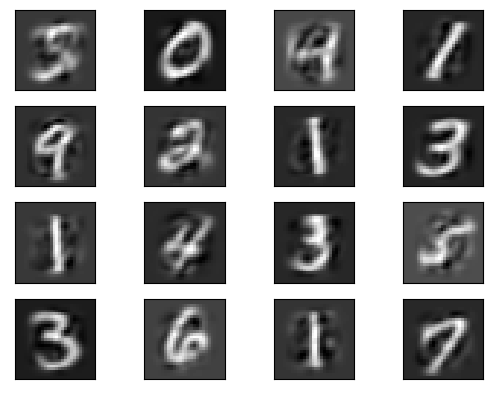

In [32]:
nn100lin = N(nn100[0](cuimages))
nn100nonlin = N(nn.Sequential(nn100[:2])(cuimages))
nn100recon2 = dot(nn100nonlin, dot(pinv(nn100nonlin), images))
showgrid(nn100recon2)

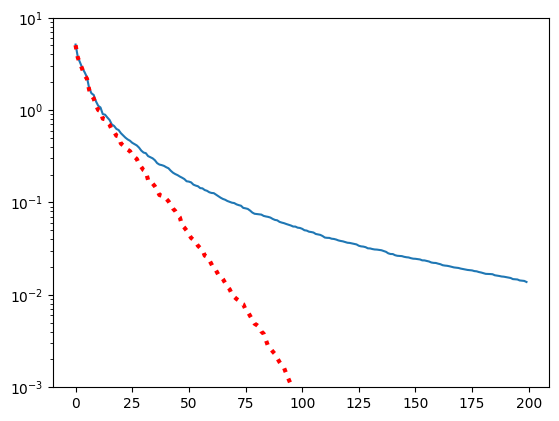

In [33]:
yscale("log"); ylim((1e-3, 1e1))
plot_pca_variance(images, 200)
plot_pca_variance(nn100recon2, 200, linestyle="dotted", color="red", linewidth=3)

# SUMMARY

Information loss happens in the non-linear layer.

## Non-Gaussianity via Kurtosis

Can we decide whether input layers are performing PCA or ICA?

In [34]:
pca = decomposition.PCA(100)
pca.fit(images.reshape(len(images), -1))
ica = decomposition.FastICA(100, whiten="arbitrary-variance")
ica.fit(images.reshape(len(images), -1))
ica_basis = ica.inverse_transform(diag(ones(100))).reshape(100, 28, 28)

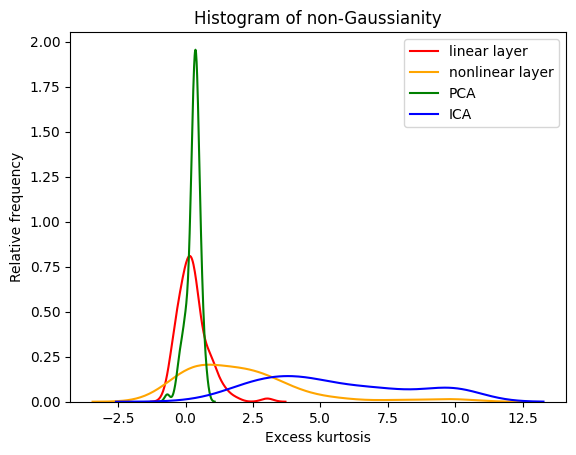

In [35]:
# measures of non-Gaussianity: higher order moments

def skew(v):
    return sqrt(len(v)) * sum((v-mean(v))**3) / sum((v-mean(v))**2)**1.5

def excess_kurtosis(v): 
    return len(v) * sum((v-mean(v))**4) / maximum(1e-5, sum((v-mean(v))**2)**2) - 3

def feature_hist(features, kind=excess_kurtosis, xlog=False, maxk=10, **kw):
    data = array([kind(v) for v in features.T])
    if xlog: data = log10(maximum(1e-12, abs(data)))
    data = minimum(data, maxk)
    sns.kdeplot(data, **kw)
    # sns.distplot(data, **kw)
    # hist(data, histtype="step", **kw)
# comparing input layer, PCA, and ICA

feature_hist(nn100lin, color="red", label="linear layer")
feature_hist(nn100nonlin, color="orange", label="nonlinear layer")

feature_hist(pca.transform(images), color="green", label="PCA")
feature_hist(ica.transform(images), color="blue", label="ICA")

title("Histogram of non-Gaussianity")
xlabel("Excess kurtosis")
ylabel("Relative frequency")
legend()

# SUMMARY

The linear input layer generates distributions that are close to PCA distributions of non-Gaussianity.

After the non-linearity, we see non-Gaussian distributions in the neural network comparable to ICA.

## PCA/ICA Input + Sigmoid + Output Layer

Since the input layer is so similar to a PCA transform, what happens if we actually replace it with PCA?

Since PCA isn't necessary "shifted" the right way relative to the nonlinearity, we add a BatchNorm1d layer, which learns a scale and bias separately for each feature.

In [36]:
k = 100
pca = decomposition.PCA(k)
pca.fit(images.reshape(len(images), -1))
pcaimages = torch.FloatTensor(pca.transform(images))
pca_ds = [(pcaimages[i], classes[i]) for i in range(60000)]

First, we explicitly transform the input images into PCA space.

In [37]:
k = len(pca.components_)

def make_pca_model():
    return nn.Sequential(nn.BatchNorm1d(k),
                         nn.ReLU(),
                         nn.Linear(k, 10)).to(device)

Next, we create a model that uses the PCA outputs as inputs. Since we don't know the absolute scale of the PCA components, we add a batch norm layer to linearly transform the activation of each component.

In [38]:
pcamodel = make_pca_model()
train_mnist(pcamodel, pca_ds)

torch.Size([256, 100])
 0 loss 0.743 err 0.198
10 loss 0.316 err 0.094
20 loss 0.303 err 0.088
30 loss 0.300 err 0.087
40 loss 0.294 err 0.086
50 loss 0.293 err 0.086


In [39]:
ica = decomposition.PCA(k)
ica.fit(images.reshape(len(images), -1))
icaimages = torch.FloatTensor(pca.transform(images))
ica_ds = [(icaimages[i], classes[i]) for i in range(60000)]

In [40]:
icamodel = make_pca_model()
train_mnist(icamodel, ica_ds)

torch.Size([256, 100])
 0 loss 0.750 err 0.200
10 loss 0.314 err 0.092
20 loss 0.303 err 0.089
30 loss 0.297 err 0.086
40 loss 0.295 err 0.086
50 loss 0.295 err 0.086


# SUMMARY

Replacing the linear input layer with a "pretrained" PCA/ICA layer results in substantially worse performance.

Therefore, there must be aspects of the linear representation found by the first layer that are not well captured by either PCA or ICA.

This is also a common kind of experiment when grafting different neural networks together (e.g., using different pretrained input layers).

## Summary (Observations)

For fully connected layers with logistic hidden units:
- linear layers are often PCA-like
- information is destroyed in the non-linear layer

## Summary (Techniques)

We have seen a number of useful experiments/tools:

- PCA, ICA, RICA, pseudo-inverse
- use measures of non-Gaussianity to determine whether layers aim for complete representation, non-Gaussianity, sparsity
- grafting together different networks
- techniques can be generalized by replacing linear methods with DNNs (at the cost of optimality)